In [ ]:
!pip install textstat
!pip3 install wordfreq


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 5.3 MB/s 
     |████████████████████████████████| 2.0 MB 27.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56.8 MB 1.2 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 


In [ ]:
import textstat
import wordfreq
#import spacy
import pandas as pd
#from textstat.textstat import textstatistics,legacy_round
from textstat.textstat import textstatistics
import numpy as np
import re
from wordfreq import word_frequency
from wordfreq import zipf_frequency
from wordfreq import tokenize
from wordfreq import get_frequency_dict
from wordfreq import top_n_list
from scipy import stats
import matplotlib.pyplot as plt
import scipy.stats as stat
import pylab 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read data
data = pd.read_excel("/content/drive/MyDrive/B4/Data/English_Exercises.xlsx")


In [ ]:
data.head()

,Exo_type_id,Exo_type,Exo_objective,Exo_focus,Exo_id,Source_format,Target_format,Source_sentence_id,Source_word_id,Source_lang,...,Instruction,Sentence_w_blank,Right_answer,Options,Explanation,Difficulty,Remediation,dist_1,dist_2,dist_3
0,10,Flashcards,Learning vocabulary,NaN,1,text,text,NaN,1.0,French,...,NaN,Beauté,Beauty,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,Flashcards,Learning vocabulary,NaN,2,text,text,NaN,2.0,French,...,NaN,Verité,Truth,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,Flashcards,Learning vocabulary,NaN,3,text,text,NaN,3.0,French,...,NaN,Liberté,Freedom,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,Flashcards,Learning vocabulary,NaN,4,text,text,NaN,4.0,French,...,NaN,Fraternité,Brotherhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,Flashcards,Learning vocabulary,NaN,5,text,text,NaN,5.0,French,...,NaN,Bonté,Kindness,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data["Exo_objective"].unique()

array(['Learning vocabulary', nan, 'Grammar', 'Verb_Conjugation'],
      dtype=object)

In [ ]:
#select non na sentences
df = data[data['Full_sentence'].notna()]


In [ ]:
#subset exo objective for vocabularis
df_vocab = df[df["Exo_objective"]=="Learning vocabulary"]

In [ ]:
#subset exo objective for grammar
df_gram = df[df["Exo_objective"]=="Grammar"]

In [ ]:

def fill_blank(blank_sentence):
    """
    Replace ... with contents from brackets i.e answer
    Remove content inside parentheses
    Remove parentheses

    """
    answer = blank_sentence[blank_sentence.find("(")+1:blank_sentence.find(")")]

    return re.sub("\(.*?\)","()", blank_sentence.replace("...", answer)).replace('(','').replace(')','')

In [ ]:
#fill sentences when there are blanks 
df_gram["Full_sent2"] = df_gram["Sentence_w_blank"].apply(lambda x:fill_blank(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#subset nan type exos
df_nan = df[df['Exo_objective'].isna()]


In [ ]:
#subset dataset where 
df_nan = df_nan[df_nan["Right_answer"].notna()]

In [ ]:
#subset dataset where verb conjugation is objective
df_verb = df[df["Exo_objective"]=='Verb_Conjugation']

In [ ]:
#pre-process data like grammar
df_verb["Full_sent2"] = df_verb["Sentence_w_blank"].apply(lambda x:fill_blank(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


NEW STRATEGY :
The score is calculated as a multiplication of length of the word
and the number of occurrences in the text. In this approach the most dicult
word (the lowest score) is a combination of being long and occur least times. If
two words have similar frequency score, the longer one will now become more
dicult. In all cases the score is calculated as relative within the available text.

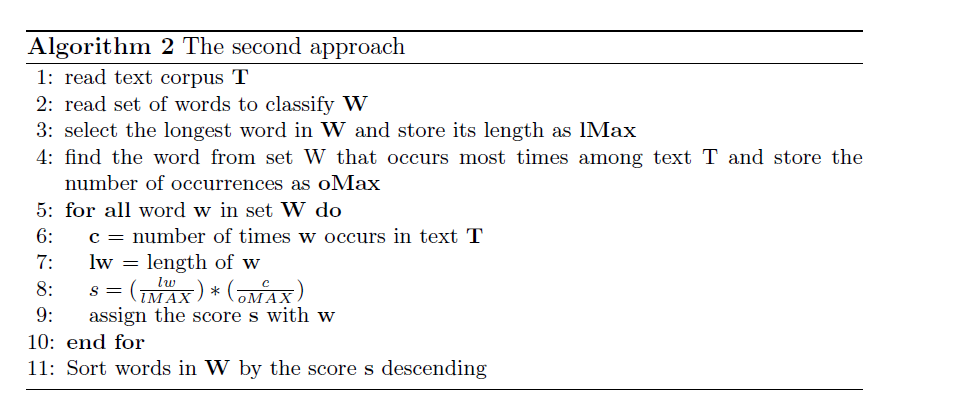

Source : https://www.researchgate.net/publication/322996917_Assessing_Word_Difficulty_for_Quiz-Like_Game

Adjustments :

First step : Have token of all texts


In [ ]:
df_vocab.head()

,Exo_type_id,Exo_type,Exo_objective,Exo_focus,Exo_id,Source_format,Target_format,Source_sentence_id,Source_word_id,Source_lang,...,Instruction,Sentence_w_blank,Right_answer,Options,Explanation,Difficulty,Remediation,dist_1,dist_2,dist_3
0,10,Flashcards,Learning vocabulary,NaN,1,text,text,NaN,1.0,French,...,NaN,Beauté,Beauty,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,Flashcards,Learning vocabulary,NaN,2,text,text,NaN,2.0,French,...,NaN,Verité,Truth,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,Flashcards,Learning vocabulary,NaN,3,text,text,NaN,3.0,French,...,NaN,Liberté,Freedom,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,Flashcards,Learning vocabulary,NaN,4,text,text,NaN,4.0,French,...,NaN,Fraternité,Brotherhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,Flashcards,Learning vocabulary,NaN,5,text,text,NaN,5.0,French,...,NaN,Bonté,Kindness,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For vocab, we can use just obtain subset the column right answer for tokens


In [ ]:
df_tokens =pd.DataFrame()

In [ ]:
df_vocab["Right_answer"].unique()

array(['Beauty', 'Truth', 'Freedom', ..., 'Wear', 'carrier', 'servants'],
      dtype=object)

In [ ]:
token_list = []
def tokenize_wordfreq(x):
    
    token_list.extend(tokenize(x,'en'))
    return tokenize(x,'en')

In [ ]:
len(token_list)

0

In [ ]:
#get tokens from vocab df
df_tokens["unigrams"] = df_vocab["Right_answer"].apply(tokenize_wordfreq)


In [ ]:
len(token_list)

In [ ]:
df_tokens["unigrams"] = df_gram["Full_sent2"].apply(tokenize_wordfreq)


In [ ]:
df_tokens["unigrams"] = df_verb["Full_sent2"].apply(tokenize_wordfreq)


In [ ]:
df_tokens["unigrams"] = df_nan["Right_answer"].apply(tokenize_wordfreq)


In [ ]:
#get unique list of tokens 
token_list = list(set(token_list))

In [ ]:
#find longest word in token list
max(token_list, key=len)

'gastroenterologist'

In [ ]:
#store length of word
imax = len(max(token_list, key=len))

find the word from set W that occurs most times among text T and store the
number of occurrences as oMax:

To do so, we find the top word from wordfreq and the number of occurences, we obtain the zipf

In [ ]:
top_n_list('en', 1, wordlist='best')

['the']

In [ ]:
zipf_frequency('the','en')

7.73

In [ ]:
omax = zipf_frequency('the','en')

In [ ]:
#create new df to find difficulty of each word
data ={"word":token_list}
df_word_diff = pd.DataFrame(data)

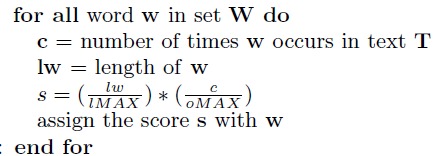

Now implementing this portion of the algorithm 

In [ ]:

def find_length(word):
    length_word = len(word)
    zipf_word = zipf_frequency(word,'en')
    relative_length = 1/length_word
    relative_freq = zipf_word/omax
    score = relative_length * relative_freq
    print(score)
    return pd.Series([length_word, zipf_word,score])

In [ ]:
df_word_diff[['length','zipf_freq','score']] = df_word_diff['word'].apply(find_length)


Streaming output truncated to the last 5000 lines.
0.06662354463130658
0.06662354463130658
0.06662354463130658
0.06662354463130658
0.06662354463130658
0.0666235446313066
0.0666235446313066
0.0666235446313066
0.0666235446313066
0.06669541469024003
0.06669541469024003
0.06669541469024003
0.06671594899279244
0.06671594899279244
0.0667529107373868
0.06678525226390684
0.06678525226390684
0.06678525226390684
0.06678525226390684
0.06678525226390684
0.06683915480810694
0.06683915480810694
0.06683915480810694
0.06683915480810694
0.06683915480810694
0.06683915480810694
0.06683915480810694
0.06690075771576418
0.06690075771576418
0.06690075771576418
0.06690075771576418
0.06690075771576418
0.06690075771576418
0.06690075771576418
0.06690075771576418
0.06690075771576418
0.06690075771576418
0.06690075771576418
0.0669469598965071
0.0669469598965071
0.0669469598965071
0.06698289492597384
0.06698289492597384
0.06698289492597384
0.06698289492597384
0.06705476498490728
0.06705476498490728
0.067054764984907

In [ ]:
#sort dataframe by ascending order
df_word_diff.sort_values(by='score',ascending=True,inplace=True,ignore_index=True)


In [ ]:
df_word_diff[df_word_diff['word']=="the"]

,word,length,zipf_freq,score
8558,the,3.0,7.73,0.333333


Higher score means easy word, lower score means harder word

In [ ]:
df_word_diff['score'].median()

0.07390038809831824

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36de601ad0>]],
      dtype=object)

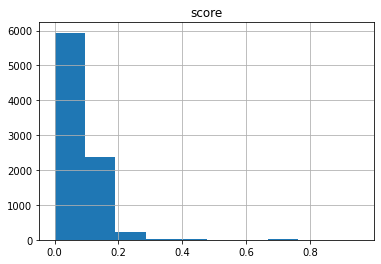

In [ ]:
df_word_diff.hist(column='score')


In [ ]:
df_word_diff['log_score']=np.log(df_word_diff['score'])


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log is not a good transformation because of zeros so we use Box-cox transformation

In [ ]:
#### If you want to check whether feature is gaussian or normal distributed
#### Q-Q plot
def plot_data(df,feature):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()
    

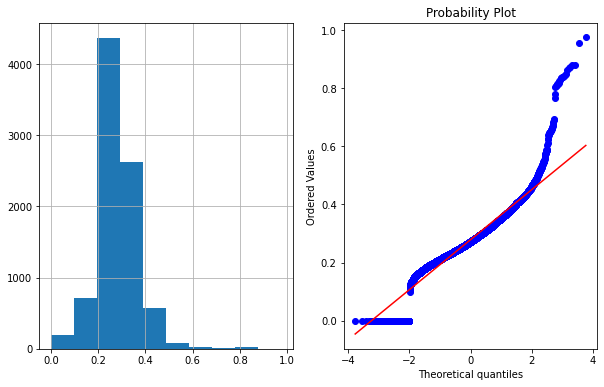

In [ ]:
##### Square Root Transformation
df_word_diff['sqrt_score']=df_word_diff.score**(1/2)
plot_data(df_word_diff,'sqrt_score')

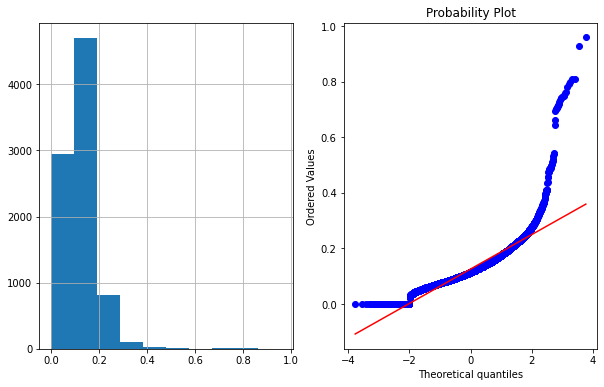

In [ ]:
#### Exponential Transdormation
df_word_diff['expo_score']=df_word_diff.score**(1/1.2)

plot_data(df_word_diff,'expo_score')

In [ ]:
df_word_diff['box_score'],parameters=stat.boxcox(df_word_diff['score']+0.1)


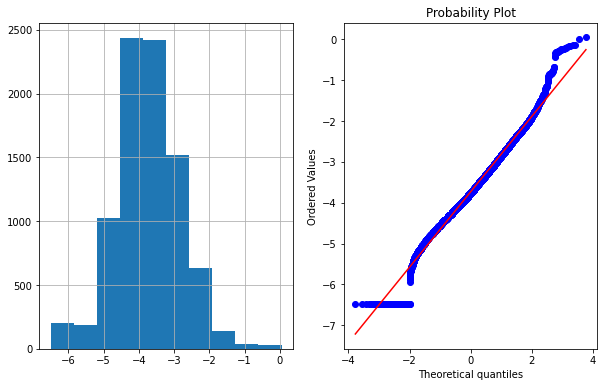

In [ ]:
plot_data(df_word_diff,'box_score')


> With boxcox transformation, the data seems closer to be gaussian hence this is feature transformation of choice

> As difficulty level, I would define that after the a certain percentile, I would define the word as easy

> The difficulty lies which percentile to choose?
Edgar Dale and Jeanne Chall instead used a list of 763 words that 80% of fourth-grade students were familiar with, such as "no", "yes", and other such very basic words to determine which words were difficult.
Inspiring from such an idea, we decide to use the cut-off point at the 20th percentile to decide between easy and difficult words


In [ ]:
 np.percentile(df_word_diff.box_score, 20)

-4.42329124192527

In [ ]:
#categorise words into difficulties
#if word is less than 20th percentile, then it is a difficult word
def determine_complex_words(box_score):
  if box_score <=  np.percentile(df_word_diff.box_score, 20):
    level = "difficult"
  else:
    level = "easy"
  return level


In [ ]:
df_word_diff["level"] = df_word_diff["box_score"].apply(lambda x:determine_complex_words(x))

In [ ]:
#list of difficult words
difficult_word_list = df_word_diff[df_word_diff["level"]=="difficult"]["word"].to_list()

# Creating the adjusted Gunning Fog


GFI (Gunning-Fog Index) = average word per sentence + percentage of complex words

#Testing demo on vocab words

In [ ]:
textstat.lexicon_count("I am monkey", removepunct=True)


3

In [ ]:
difficult_word_list

['acquite',
 'thirthieth',
 'vermifuges',
 'teenagehood',
 'clandestineness',
 'durinf',
 'newsvendor',
 'defeaning',
 'persever',
 'repairings',
 'drainboard',
 'recrudences',
 'forgived',
 'pillowscases',
 'chimpazee',
 'assaluted',
 'poisonning',
 'neighboors',
 'prsetigious',
 'pueril',
 'echography',
 'enlighting',
 'kindney',
 'witiness',
 'desertes',
 'diall',
 'plancton',
 'bulbl',
 'independences',
 'descreetly',
 'cockrow',
 'coak',
 'yesn',
 'evenhand',
 'overf',
 'occure',
 'rethinked',
 'oxygened',
 'luggagge',
 'vulcanologists',
 'professionnal',
 'dirrhea',
 'reproductibility',
 'honnestly',
 'perosn',
 'canari',
 'orphane',
 'tarentulas',
 'applaused',
 'tetanos',
 'fashionned',
 'instictively',
 'extraordinarly',
 'deplet',
 'receptionnist',
 'arrestation',
 'functionning',
 'substractions',
 'neighboorhood',
 'utangs',
 "menem's",
 'forbidded',
 'nightclubb',
 'punishement',
 'misdial',
 'swated',
 'deseed',
 'unoccupy',
 'glassfuls',
 'acquited',
 'dailypaper',
 'any

In [ ]:
def is_difficult_word(word):
  if word in difficult_word_list :
    return True
  else:
    return False

In [ ]:
def difficult_words(text):
  words = set(re.findall(r"[\w\='‘’]+", text.lower()))
  diff_words = [word for word in words
                      if is_difficult_word(word)]
  return len(diff_words)


In [ ]:
 def avg_sentence_length( text: str) -> float:
        """Calculate the average sentence length.
        This function is a combination of the functions `lexicon_count` and
        `sentence_count`.
        Parameters
        ----------
        text : str
            A text string.
        Returns
        -------
        float
            The average sentence length.
        """
        try:
            asl = float(textstat.lexicon_count(text) / textstat.sentence_count(text))
            return np.round(asl, 1)
        except ZeroDivisionError:
            return 0.0

In [ ]:
 def gunning_fog( text: str) -> float:
        try:
            per_diff_words = (
                difficult_words(
                    text)
                    / textstat.lexicon_count(text) * 100)
            

            grade = (avg_sentence_length(text) + per_diff_words)
            return np.round(grade, 2)
        except ZeroDivisionError:
            return 0.0

> ### Works well with sentences but with words, for E.g for vocabulary exercises, it can give either a score of 101 and 1, 101 for difficult words(exist in difficult word list) or score of 1 simply because of the formula

> for e.g "polyglot" is a difficult word so according to the formula, it is per_diff_words = 100 and avg_sentence_length = 1, so 100 + 1 = 101

Now let's test on dataset

101.0

In [ ]:
df_vocab["Difficulty"] = df_vocab["Right_answer"].apply(lambda x:gunning_fog(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#apply function to df_gram
df_gram["Difficulty"] = df_gram["Full_sent2"].apply(lambda x:gunning_fog(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#apply function to df_nan
df_nan["Difficulty"] = df_nan["Right_answer"].apply(lambda x:gunning_fog(x))

In [ ]:
#apply function to df_verb
df_verb["Difficulty"] = df_verb["Full_sent2"].apply(lambda x:gunning_fog(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#drop column of complete sentence to ensure data format 
df_verb = df_verb.drop(columns=['Full_sent2'])
df_gram = df_gram.drop(columns=['Full_sent2'])


Stack all 4 Dataframes together

In [ ]:
final_df = pd.concat([df_vocab,df_gram,df_nan, df_verb], ignore_index=True, axis=0)


In [ ]:
final_df.head()

,Exo_type_id,Exo_type,Exo_objective,Exo_focus,Exo_id,Source_format,Target_format,Source_sentence_id,Source_word_id,Source_lang,...,Instruction,Sentence_w_blank,Right_answer,Options,Explanation,Difficulty,Remediation,dist_1,dist_2,dist_3
0,10,Flashcards,Learning vocabulary,NaN,1,text,text,NaN,1.0,French,...,NaN,Beauté,Beauty,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,10,Flashcards,Learning vocabulary,NaN,2,text,text,NaN,2.0,French,...,NaN,Verité,Truth,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,10,Flashcards,Learning vocabulary,NaN,3,text,text,NaN,3.0,French,...,NaN,Liberté,Freedom,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,10,Flashcards,Learning vocabulary,NaN,4,text,text,NaN,4.0,French,...,NaN,Fraternité,Brotherhood,NaN,NaN,101.0,NaN,NaN,NaN,NaN
4,10,Flashcards,Learning vocabulary,NaN,5,text,text,NaN,5.0,French,...,NaN,Bonté,Kindness,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [241]:
final_df.to_csv("/content/drive/MyDrive/B4/Data/English_Exercises_diff.csv",index=False)